In [1]:
# Dependencies
import requests as req
import numpy as np
from scipy import stats
import json
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
###############################################################################
# Income and Education DataFrames to use:
    # By County:
        # By Value:
            # incomeDFmapped - INCOME
            # eduDFmapped - EDUCATION
        # Normalized
            # normIncome - INCOME
            # normEdu - EDUCATION
    # By State:
        # By Value:
            # incomeByState - INCOME
            # eduByState - EDUCATION
        # Normalized
            # incomeByStateNorm - INCOME
            # eduByStateNorm - EDUCATION
###############################################################################

##### MAP GEOCODES (FIPS) TO STATES/COUNTIES #####
# Create function to make Geocode Data into DataFrame
def makeGeocodeDF(pdExel,sumLevel,fipsCol1,colName,fipsCol2=0):
    # Create DF out of excel
    df = pdExel.loc[pdExel['Summary Level'] == sumLevel]

    # If the summary level is 'county'
    if sumLevel == 50:
        # Add both fips code levels
        df = df[[fipsCol1,fipsCol2,'Area Name (including legal/statistical area description)']]
    else:
        # only add one fips code level
        df = df[[fipsCol1,'Area Name (including legal/statistical area description)']]

    # Rename columns
    df = df.rename(columns={'Area Name (including legal/statistical area description)' : colName})

    # Return DataFrame
    return df

# Read excel file of geo codes
geocodeMap = pd.read_excel('resources/2015-allgeocodes.xlsx', sheetname='Sheet1')

# Create DataFrame of States/State FIPS
geocodeMapState = makeGeocodeDF(geocodeMap,40,'State Code (FIPS)','State')
# Create DataFrame of County Names/County FIPS/State FIPS/
geocodeMapCounty = makeGeocodeDF(geocodeMap,50,'County Code (FIPS)','County','State Code (FIPS)')
# Create DataFrame of States and Abbreviations
abbrMap = pd.read_excel('resources/stateAbbreviation.xlsx')

# Create merged DataFrame with County and State FIPS and Names
geocodeMap = pd.merge(geocodeMapState,geocodeMapCounty, how='outer', on='State Code (FIPS)')

#/ Variables/DFs to use:
    #/ For state/county mapping: geocodeMap
    #/ remember to merge on BOTH State and County (county FIPs repeat)

##### CENSUS DATA #####
#/// SETUP 'GET' Variables \\\#
# Function to dynamically create variable ID lists
def createIdList(r1,r2,s,avoid=[]): #range start, range stop, id string, avoid ids (optional)

    i = [] # List variable

    # For all variables in the range
    for x in range(r1,r2):

        # If there are variables to avoid, pass
        if x in avoid:
            pass

        # If id is greater than 9
        elif x > 9:
            i.append(s+str(x)+'E')

        # Add a leading zero for IDs below 10
        else:
            i.append(s+'0'+str(x)+'E')

    # Return list
    return i

# Function to create a dictionary of IDs and their string
def createIdDict(k,v):

    n = 0 #counter
    d = {} #dictionary

    # For each ID in list
    for x in k:

        # Add it as a key and add appropriate bucket as value
        d[x] = v[n%len(v)] #use remainder to determine bucket (if it loops)
        n += 1 # Increase counter

    # Rename state/county to match geomap
    d['state'] = 'State Code (FIPS)'
    d['county'] = 'County Code (FIPS)'

    # Return Dictionary
    return d

# HOUSEHOLD INCOME: Create List and Dictionary
householdIncomeIdList = createIdList(2,18,'B19001_0')
householdIncomeBuckets = ['< $10k',
                          '$10K - $14,999',
                          '$15K - $19,999',
                          '$20K - $24,999',
                          '$25K - $29,999',
                          '$30K - $34,999',
                          '$35K - $39,999',
                          '$40K - $44,999',
                          '$45K - $49,999',
                          '$50K - $59,999',
                          '$60K - $74,999',
                          '$75K - $99,999',
                          '$100K - $124,999',
                          '$125K - $149,999',
                          '$150K - $199,999',
                          '$200K +']
householdIncomeDict = createIdDict(householdIncomeIdList,householdIncomeBuckets)

# EDUCATIONAL ATTAINMENT: Create List and Dictionary
notInclude = [1,2,3,11,19,27,35,43,44,52,60,68,76] #id's not to include in list
educationIdList = createIdList(1,84,'B15001_0',notInclude)
educationAttainmentBuckets = ['Less than 9th grade',
                              '9th to 12th grade, no diploma',
                              'High school graduate',
                              'Some college, no degree',
                              'Associate\'s degree',
                              'Bachelor\'s degree',
                              'Graduate or professional degree']
educationDict = createIdDict(educationIdList,educationAttainmentBuckets)
# Split education list in 2 because of 50 variable arg max
educationIdList1 = educationIdList[:int(len(educationIdList)/2)]
educationIdList2 = educationIdList[int(len(educationIdList)/2):]

# POPULATION: Create Dictionary
populationDict = createIdDict(['B01001_001E'],['Population'])

# Create string of ID's to query
idLists = [householdIncomeIdList,educationIdList1,educationIdList2] # List of lists
getArgs = []

# Create list of get arguments (all id's)
for l in idLists:

    getIds = '' #string

    # For all IDs in the list
    for i in l:

        getIds = getIds + i + ',' #add ID to final string

    getIds = getIds[:-1] #remove last comma
    getArgs.append(getIds) #add to ID list

# Append population to get args
getArgs.append((list(populationDict.keys()))[0])

#/// Setup Query URL \\\#
# Variables
year = 2016
apiKey = 'a9bba28cbc522f8f9d8ae3b88ef030fba6034516'
baseURL = 'https://api.census.gov/data/{}/acs/acs1/'.format(year)
forArgs = 'county:*'

# Create list of URLs to query
urlList = [] #empty list
for x in getArgs:
    URLArgs = '?get={}&for={}&key={}'.format(x,forArgs,apiKey)
    queryURL = baseURL + URLArgs
    urlList.append(queryURL)


#/// Create Dataframes \\\#
# Create function
def makeDataFrame(url,labelDict):

    #Get response data from API
    response = req.get(url)
    jsonData = response.json() #create json

    # Create data frame from json
    df = pd.DataFrame(jsonData, columns=jsonData[0]) #rename headers with first row values
    df = df.rename(columns=labelDict) #rename columnns using associated dictionary
    df = df.drop(df.index[0]) #remove first row

    # Remove leading zeros from state and county
    df['State Code (FIPS)'] = df['State Code (FIPS)'].str.lstrip('0')
    df['County Code (FIPS)'] = df['County Code (FIPS)'].str.lstrip('0')

    # Make all numbers in DF numeric
    df = df.apply(pd.to_numeric)

    return df

# Make DF using Function
incomeDF = makeDataFrame(urlList[0],householdIncomeDict)
eduDF1 = makeDataFrame(urlList[1],educationDict)
eduDF2 = makeDataFrame(urlList[2],educationDict)
populationDF = makeDataFrame(urlList[3],populationDict)

#/// Merge Education DataFrames \\\#
# Create joint DF
eduDF = pd.merge(eduDF1,eduDF2,how='outer',on=['State Code (FIPS)','County Code (FIPS)'])

# Create dictionary to remove appeneded X's and Y's on column names
removeAppend = {}
for i in educationAttainmentBuckets:
    s1 = i + '_x'
    s2 = i + '_y'
    removeAppend[s1] = i
    removeAppend[s2] = i

# Rename column headers
eduDF = eduDF.rename(columns=removeAppend)

# Sum columns with same names in DF
eduDF = eduDF.groupby(lambda x:x, axis=1).sum()

#/// Map Geocodes and add to DF \\\#
# Create function to automate
def mergeOnGeocode(df1,df2):
    try:
        return pd.merge(df1,df2,how='inner',on=['State Code (FIPS)','County Code (FIPS)'])
    except:
        return pd.merge(df1,df2,how='inner',on=['State Code (FIPS)'])


# Map census DFs to FIPS
incomeDFmapped = mergeOnGeocode(incomeDF,geocodeMap)
eduDFmapped = mergeOnGeocode(eduDF,geocodeMap)

popDFmapped = mergeOnGeocode(populationDF,geocodeMap)
popDFmapped = pd.merge(popDFmapped,abbrMap, how='inner',on=['State'])

#/ Variables/DFs to use:
    #/ To normalize data, use this DF: popDFmapped (FIPS mapped to names)
    #/ Income data DF to use: incomeDFmapped (FIPS mapped to names) or incomeDF (FIPS only)
    #/ Education data DF to use: eduDFmapped (FIPS mapped to names) or eduDF (FIPS only)

In [3]:
#/// Create Normalized DFs \\\*

# Create function to normalize data
def normalizeData(df1,df2,buckets):

    # Merge dicts on geocode
    df = mergeOnGeocode(df1,df2)

    # For each column, divide by the total population column
    for bucket in buckets:
        df[bucket] = df[bucket]/df['Population']

    # Drop population column
    df.drop(['Population'], axis=1, inplace=True)

    # Return df
    return df

# HOUSEHOLDS TOTAL: Create DF
var = 'B19001_001E'
householdDict = createIdDict([var],['Population']) #create dict

URLArgs = '?get={}&for={}&key={}'.format(var,forArgs,apiKey)
queryURL = baseURL + URLArgs #put together query URL

householdDF = makeDataFrame(queryURL,householdDict) #create DF

# +18 POPULATION TOTAL: Create DF
var = 'B15001_001E'
over18Dict = createIdDict([var],['Population']) #create dict

URLArgs = '?get={}&for={}&key={}'.format(var,forArgs,apiKey)
queryURL = baseURL + URLArgs #put together query URL

over18DF = makeDataFrame(queryURL,over18Dict) #create DF

# Normalize Income and Education DFs
normIncome = normalizeData(incomeDF,householdDF,householdIncomeBuckets) #normalizedIncome
normEdu = normalizeData(eduDF,over18DF,educationAttainmentBuckets) #normalizedEdu

#/// Create Normalized DFs for States \\\*

# Function to breakdown DFs by state FIPS
def breakdownByState(dfIn):
    df = dfIn.groupby(['State Code (FIPS)']).sum()
    df.drop(['County Code (FIPS)'], axis=1, inplace=True)
    df = df.reset_index()
    return df

# Function to set state as index
def setStateAsIndex(df):

    # Merge on state only
    df = mergeOnGeocode(df,geocodeMapState)
    df.drop('State Code (FIPS)', axis=1, inplace=True)
    df = df.set_index('State')
    return df

# Function to Normalize state DFs
def createStateNormDF (df1,df2,buckets):

    # Breakdown DFs by STate and Normalize
    df1n = breakdownByState(df1)
    df2n = breakdownByState(df2)
    df = normalizeData(df1n,df2n,buckets)

    # Set state as the index
    df = setStateAsIndex(df)

    return df

# Create State DF's
# Income
incomeByState = setStateAsIndex(breakdownByState(incomeDF))
incomeByState = incomeByState[householdIncomeBuckets] #reorder columns
# Education
eduByState = setStateAsIndex(breakdownByState(eduDF))
eduByState = eduByState[educationAttainmentBuckets] #reorder columns

# Create State Normalized DF's
# Income
incomeByStateNorm = createStateNormDF(incomeDF,householdDF,householdIncomeBuckets)
incomeByStateNorm = incomeByStateNorm[householdIncomeBuckets] #reorder columns
# Education
eduByStateNorm = createStateNormDF(eduDF,over18DF,educationAttainmentBuckets)
eduByStateNorm = eduByStateNorm[educationAttainmentBuckets] #reorder columns

# Reduce income buckets
def reduceBuckets(df):
    df['< $25K'] = df[householdIncomeBuckets[0]] + df[householdIncomeBuckets[1]] + df[householdIncomeBuckets[2]] + df[householdIncomeBuckets[3]]
    df['\$25K - $49,999'] = df[householdIncomeBuckets[4]] + df[householdIncomeBuckets[5]] + df[householdIncomeBuckets[6]] + df[householdIncomeBuckets[7]] + df[householdIncomeBuckets[8]]
    df['\$50K - $99,999'] = df[householdIncomeBuckets[9]] + df[householdIncomeBuckets[10]] + df[householdIncomeBuckets[11]]
    df['\$100K - $149,999'] = df[householdIncomeBuckets[12]] + df[householdIncomeBuckets[13]]

    df = df[['< $25K',
             '\$25K - $49,999',
             '\$50K - $99,999',
             '\$100K - $149,999',
             '$150K - $199,999',
             '$200K +'
            ]]
    
    df = df.rename({'$150K - $199,999' : '\$150K - $199,999'})
    
    return df

# Run function on income to reduce buckets
incomeByStateBuckets = reduceBuckets(incomeByState) #volume
incomeByStateNormBuckets = reduceBuckets(incomeByStateNorm) #normalized

In [4]:
# Household income volume
incomeByState.head()

,< $10k,"$10K - $14,999","$15K - $19,999","$20K - $24,999","$25K - $29,999","$30K - $34,999","$35K - $39,999","$40K - $44,999","$45K - $49,999","$50K - $59,999","$60K - $74,999","$75K - $99,999","$100K - $124,999","$125K - $149,999","$150K - $199,999",$200K +,< $25K,"\$25K - $49,999","\$50K - $99,999","\$100K - $149,999"
State,,,,,,,,,,,,,,,,,,,,
Alabama,117740,82051,81954,77103,75533,73493,69537,64044,57363,109256,130940,163814,106967,57537,60731,54724,358848,339970,404010,164504
Alaska,5148,4504,4093,5404,5336,5885,4815,5904,6524,13298,16693,24791,21870,13700,17154,14205,19149,28464,54782,35570
Arizona,178550,118827,113126,125785,125696,120881,120530,125073,103507,214202,247124,309522,195761,116701,123372,119731,536288,595687,770848,312462
Arkansas,53205,34318,33389,37538,34367,36272,30819,34560,31788,55521,64676,71239,47523,27354,25144,25572,158450,167806,191436,74877
California,688487,572418,512769,568814,485542,529878,489353,507198,450680,874479,1199686,1551800,1213874,797890,1010483,1301650,2342488,2462651,3625965,2011764


In [5]:
# Household Income Normalized
incomeByStateNorm.head()

,< $10k,"$10K - $14,999","$15K - $19,999","$20K - $24,999","$25K - $29,999","$30K - $34,999","$35K - $39,999","$40K - $44,999","$45K - $49,999","$50K - $59,999","$60K - $74,999","$75K - $99,999","$100K - $124,999","$125K - $149,999","$150K - $199,999",$200K +,< $25K,"\$25K - $49,999","\$50K - $99,999","\$100K - $149,999"
State,,,,,,,,,,,,,,,,,,,,
Alabama,0.085147,0.059337,0.059267,0.055759,0.054624,0.053148,0.050288,0.046315,0.041484,0.079011,0.094693,0.118467,0.077356,0.041609,0.043919,0.039575,0.259511,0.245859,0.292171,0.118966
Alaska,0.030403,0.026600,0.024173,0.031915,0.031514,0.034756,0.028437,0.034868,0.038530,0.078536,0.098586,0.146412,0.129161,0.080910,0.101309,0.083892,0.113091,0.168104,0.323534,0.210071
Arizona,0.072629,0.048335,0.046016,0.051166,0.051129,0.049171,0.049028,0.050876,0.042104,0.087131,0.100523,0.125904,0.079630,0.047471,0.050184,0.048703,0.218146,0.242308,0.313558,0.127100
Arkansas,0.082708,0.053348,0.051904,0.058354,0.053424,0.056386,0.047909,0.053724,0.049415,0.086309,0.100540,0.110743,0.073875,0.042522,0.039087,0.039752,0.246314,0.260858,0.297591,0.116398
California,0.053978,0.044878,0.040201,0.044595,0.038067,0.041543,0.038366,0.039765,0.035334,0.068560,0.094056,0.121662,0.095168,0.062555,0.079222,0.102050,0.183653,0.193073,0.284278,0.157724


In [6]:
# Household Income with reduced buckets (normalized)
incomeByStateNormBuckets.head()

,< $25K,"\$25K - $49,999","\$50K - $99,999","\$100K - $149,999","$150K - $199,999",$200K +
State,,,,,,
Alabama,0.259511,0.245859,0.292171,0.118966,0.043919,0.039575
Alaska,0.113091,0.168104,0.323534,0.210071,0.101309,0.083892
Arizona,0.218146,0.242308,0.313558,0.127100,0.050184,0.048703
Arkansas,0.246314,0.260858,0.297591,0.116398,0.039087,0.039752
California,0.183653,0.193073,0.284278,0.157724,0.079222,0.102050


In [7]:
# Education Attainment Volume
eduByState.head()

,Less than 9th grade,"9th to 12th grade, no diploma",High school graduate,"Some college, no degree",Associate's degree,Bachelor's degree,Graduate or professional degree
State,,,,,,,
Alabama,111784,266587,801204,694519,219221,447864,264964
Alaska,6267,18345,101141,111073,32571,70282,36635
Arizona,268015,426722,1289846,1409771,412632,869186,496777
Arkansas,51095,97309,387489,326751,81629,208442,115674
California,2591171,2414803,6425995,7160282,2181414,5739416,3242559


In [8]:
# Education Attainment Normalized
eduByStateNorm.head()

,Less than 9th grade,"9th to 12th grade, no diploma",High school graduate,"Some college, no degree",Associate's degree,Bachelor's degree,Graduate or professional degree
State,,,,,,,
Alabama,0.039835,0.095001,0.285518,0.247500,0.078122,0.159601,0.094423
Alaska,0.016654,0.048749,0.268768,0.295160,0.086553,0.186764,0.097352
Arizona,0.051811,0.082491,0.249344,0.272528,0.079767,0.168025,0.096034
Arkansas,0.040283,0.076719,0.305497,0.257611,0.064356,0.164336,0.091198
California,0.087082,0.081154,0.215959,0.240636,0.073311,0.192885,0.108973


In [9]:
#/// Create Bar Charts \\\*
sns.palplot(sns.hls_palette(9, l=.3, s=.8))

# Function to create bar charts
def createBarChart(df,title,x,y,lt,l,c,save):

    # Plot DF as bar graph
    df.plot(kind='bar',
            stacked=True,
            title=title,
            figsize=(30,10),
            fontsize=14
           )

    # Add title/labels
    plt.title(title,fontsize=18) #Create graph title
    plt.xlabel(x, fontsize=14) #Create x-axis label
    plt.ylabel(y,fontsize=14) #Create y-axis label
    plt.tick_params(axis='both', labelsize=12) #Format Axis

    # Add legend
    legend = plt.legend(loc='lower center',bbox_to_anchor=(.5, l), ncol=c, borderaxespad=0., title=lt, fontsize=12,frameon=True)
    legend.get_title().set_fontsize('14') #Set legend title font size
    
    # Show plot
    plt.show()

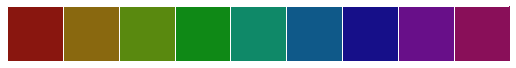

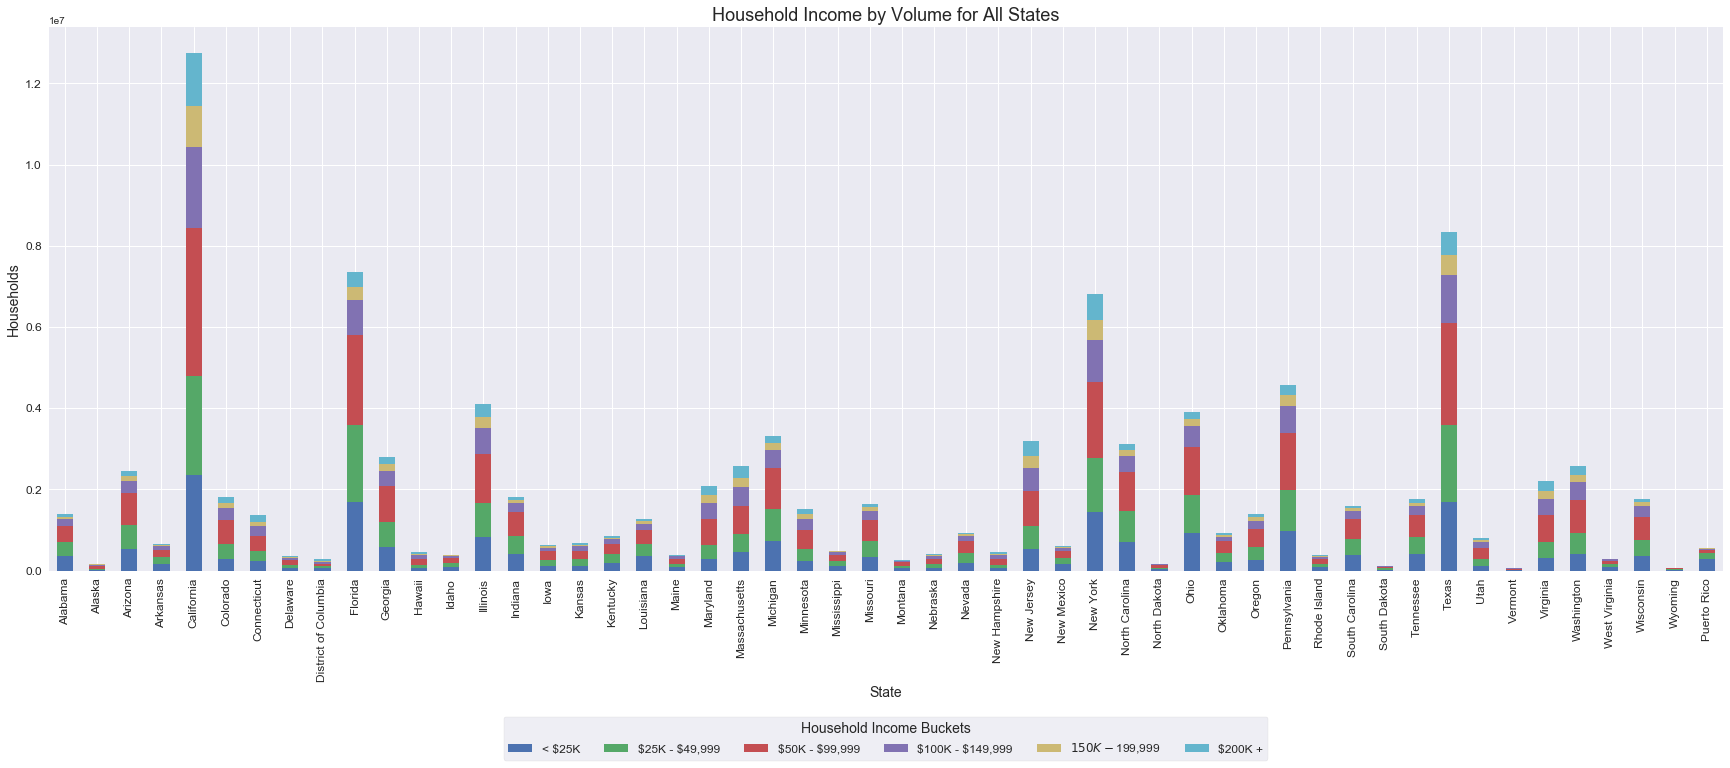

In [10]:
# Bar Chart: Household Income for All States
createBarChart(incomeByStateBuckets,'Household Income by Volume for All States','State','Households','Household Income Buckets',-.35,6,'graphs/incomebyvolume.png')

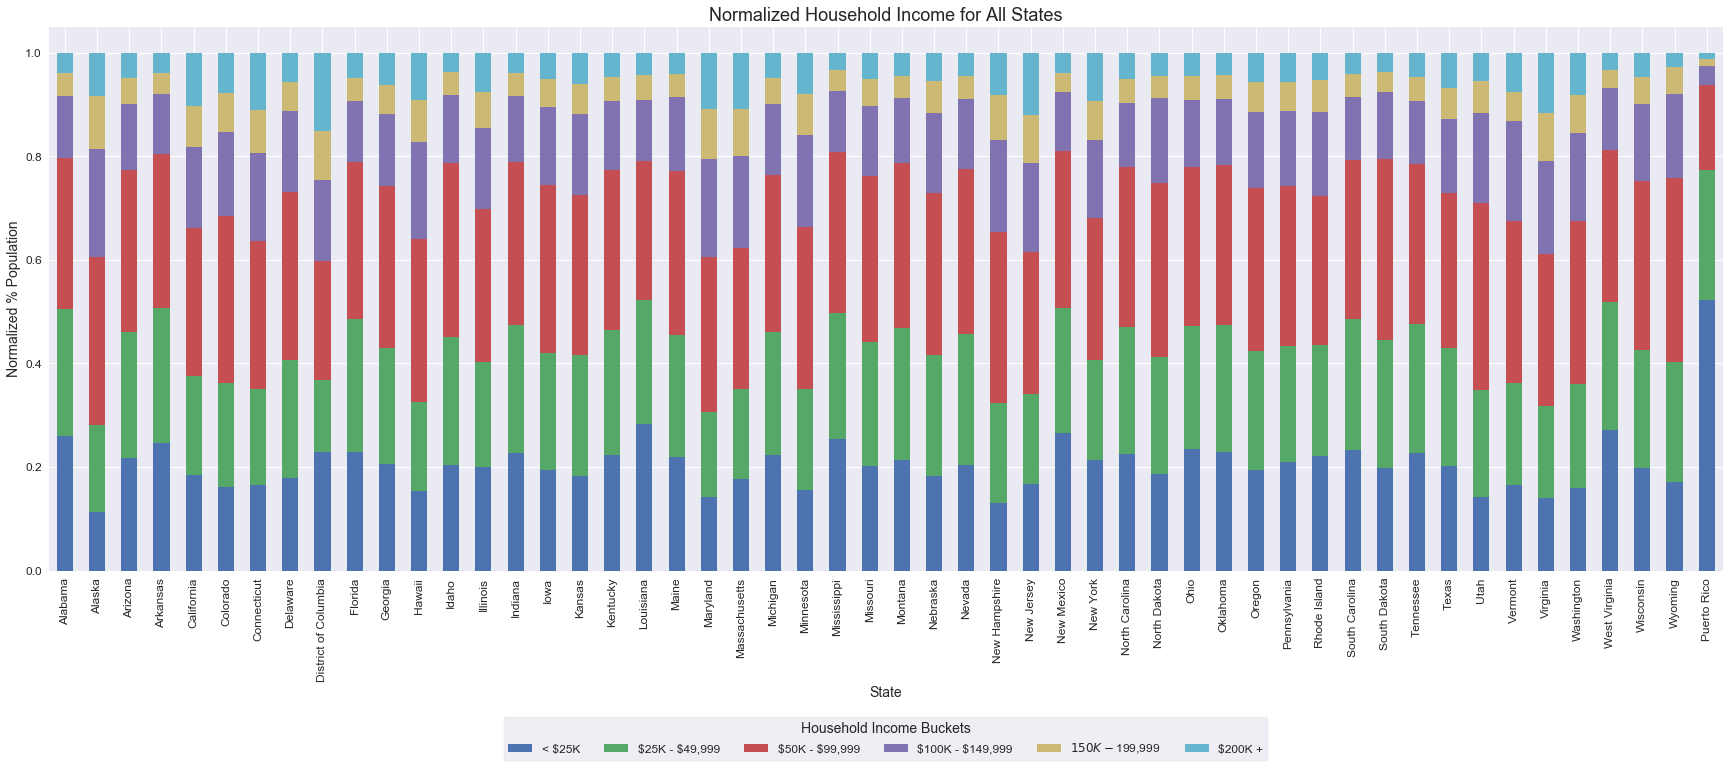

In [11]:
# Bar Chart: Normalized Household Income for All States
createBarChart(incomeByStateNormBuckets,'Normalized Household Income for All States','State','Normalized % Population','Household Income Buckets',-.35,6,'graphs/incomebynorm.png')
plt.savefig('graphs/incomebynorm.png')

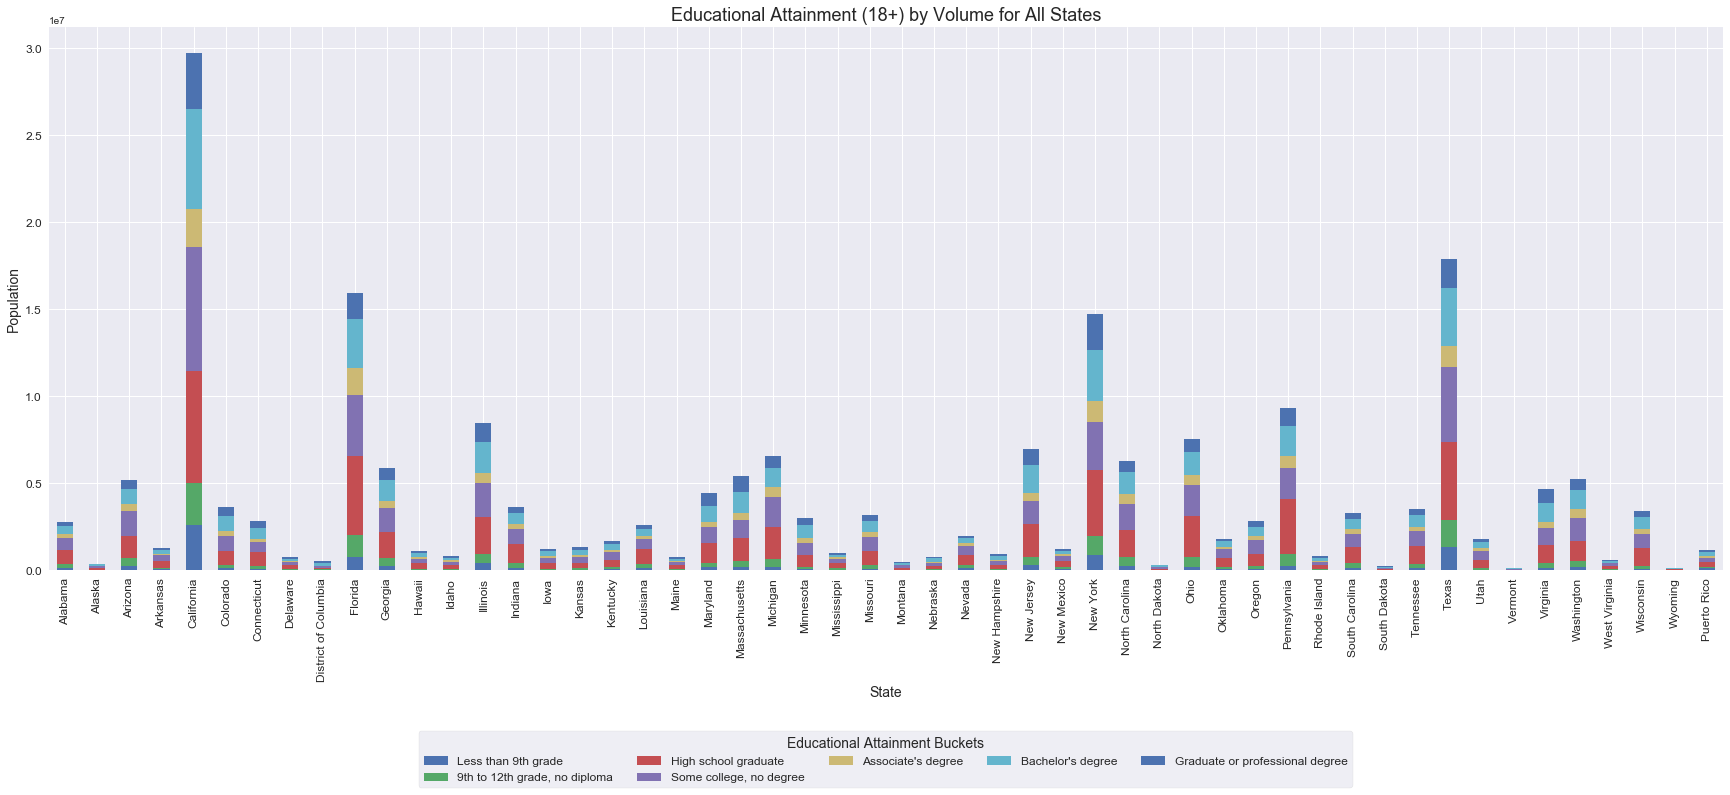

In [12]:
# Bar Chart: Educational Attainment (18+) for All States
createBarChart(eduByState,'Educational Attainment (18+) by Volume for All States','State','Population','Educational Attainment Buckets',-.4,5,'graphs/edubyvolume.png')

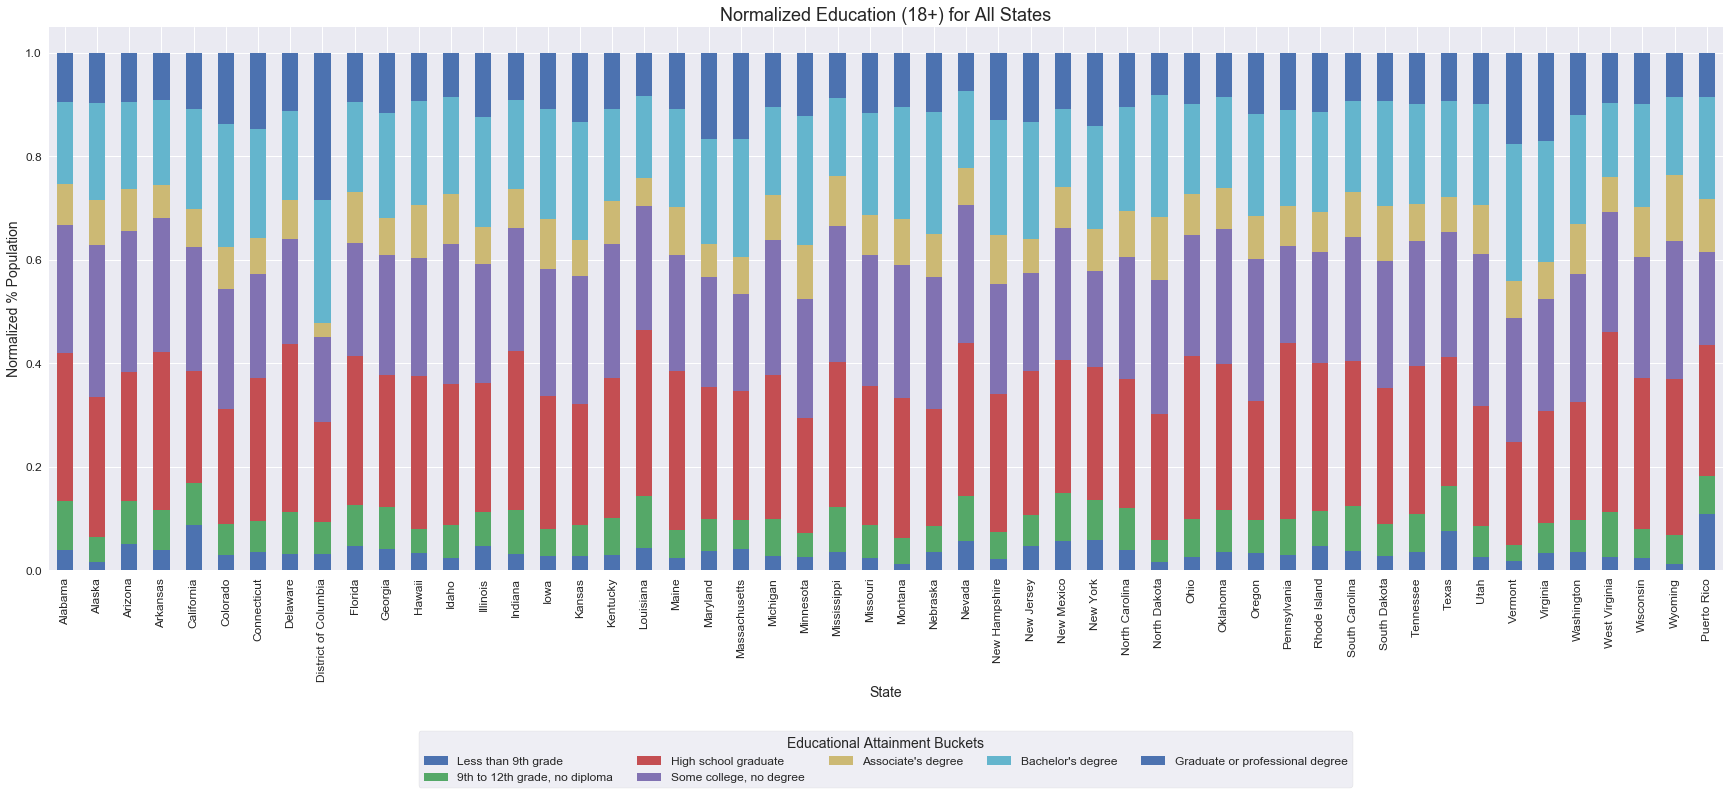

In [13]:
# Bar Chart: Normalized Education (18+) for All States
createBarChart(eduByStateNorm,'Normalized Education (18+) for All States','State','Normalized % Population','Educational Attainment Buckets',-.4,5,'graphs/edubynorm.png')

In [14]:
# MONA'S DATAFRAMES FOR COMPARISON

res_data = pd.ExcelFile('resources/FastFoodData.xls')
restaurant_df = pd.read_excel(res_data, 'RESTAURANTS')

restaurant_df = restaurant_df.rename(columns={'FFR09':'Fast Food Restaurants 2009',
                                              'FFR14':'Fast Food Restaurants 2014',
                                              'PCH_FFR_09_14':'Fast-food restaurants (% change)',
                                              'FFRPTH09':'Fast-food restaurants/1,000 pop 2009',
                                              'FFRPTH14':'Fast-food restaurants/1,000 pop 2014',
                                              'PCH_FFRPTH_09_14':'Fast-food restaurants/1,000 pop (% change)'})

fast_food_df=restaurant_df[['FIPS',
                            'State',
                            'County',
                            'Fast Food Restaurants 2009',
                            'Fast Food Restaurants 2014',
                            'Fast-food restaurants (% change)',
                            'Fast-food restaurants/1,000 pop 2009',
                            'Fast-food restaurants/1,000 pop 2014',
                            'Fast-food restaurants/1,000 pop (% change)']].copy()


# fast_food_df.head()
# fast_food_df.insert(loc=0,column='Fast Food Restaurants 2015 (PROJECTED)',value=int)

ff_df=fast_food_df[['FIPS',
                    'State',
                    'County',
                    'Fast Food Restaurants 2009',
                    'Fast Food Restaurants 2014',
                    'Fast-food restaurants (% change)',
                    'Fast-food restaurants/1,000 pop 2009',
                    'Fast-food restaurants/1,000 pop 2014',
                    'Fast-food restaurants/1,000 pop (% change)']].copy()

for index,row in ff_df.iterrows():
    total_gr = row['Fast-food restaurants (% change)']
    yr_gr = total_gr/5
    ff_df.set_value(index,'Yearly Growth Rate %',yr_gr)
    ff09 = row['Fast Food Restaurants 2009']
    ff14 = row['Fast Food Restaurants 2014']
    projection = round((ff14*(yr_gr/100)) + ff14,0)
    ff_df.set_value(index,'Fast Food Restaurants 2015 (PROJECTED)',projection)
   
    
# del ff_df['Fast-food restaurants/1,000 pop 2009']
# del ff_df['Fast-food restaurants/1,000 pop 2014']
# del ff_df['Fast-food restaurants/1,000 pop (% change)']

resbystate15 = ff_df.groupby(["State"])['Fast Food Restaurants 2015 (PROJECTED)'].sum()
resbystate14 =  ff_df.groupby(["State"])['Fast Food Restaurants 2014'].sum()
resbystate15.head(20)
resbystate=pd.DataFrame({'Abbreviation':resbystate15.index,'Fast Food Restaurant Count 2014':resbystate14.values, 'Fast Food Restaurant Count 2015 (prj)':resbystate15.values}).copy()

# Condense dataframe
resbystate2015 = resbystate[['Abbreviation','Fast Food Restaurant Count 2015 (prj)']]
resbystate2015.head()

,Abbreviation,Fast Food Restaurant Count 2015 (prj)
0,AK,425.0
1,AL,3626.0
2,AR,1963.0
3,AZ,4241.0
4,CA,28842.0


In [15]:
# Merge Mona's data with Abbreviation map
resbystate2015merged = pd.merge(resbystate2015,abbrMap,how='inner',on=['Abbreviation'])
resbystate2015merged = resbystate2015merged[['Fast Food Restaurant Count 2015 (prj)','State']]

resbystate2015merged.head()

,Fast Food Restaurant Count 2015 (prj),State
0,425.0,Alaska
1,3626.0,Alabama
2,1963.0,Arkansas
3,4241.0,Arizona
4,28842.0,California


In [16]:
# Consolidate Education budgets by Degree and no degree
eduByState['No Degree'] = eduByState['Less than 9th grade'] + eduByState['9th to 12th grade, no diploma'] + eduByState['High school graduate'] +  eduByState['Some college, no degree']
eduByState['Degree'] = eduByState['Associate\'s degree'] + eduByState['Bachelor\'s degree'] + eduByState['Graduate or professional degree']
eduByState['Total'] = eduByState['No Degree'] + eduByState['Degree']

# Degreelist = ['Less than 9th grade',
# '9th to 12th grade, no diploma',
# 'High school graduate',
# 'Some college, no degree',
# 'Associate\'s degree',
# 'Bachelor\'s degree',
# 'Graduate or professional degree']

eduByState['No Degree Normalized'] = eduByState['No Degree'] / eduByState['Total']
eduByState['Degree Normalized'] = eduByState['Degree'] / eduByState['Total']
eduByState['Less than 9th grade Normalized'] = eduByState['Less than 9th grade'] / eduByState['Total']
eduByState['9th to 12th grade, no diploma Normalized'] = eduByState['9th to 12th grade, no diploma'] / eduByState['Total']
eduByState['High school graduate Normalized'] = eduByState['High school graduate'] / eduByState['Total']
eduByState['Some college, no degree Normalized'] = eduByState['Some college, no degree'] / eduByState['Total']
eduByState['Associate\'s degree Normalized'] = eduByState['Associate\'s degree'] / eduByState['Total']
eduByState['Bachelor\'s degree Normalized'] = eduByState['Bachelor\'s degree'] / eduByState['Total']
eduByState['Graduate or professional degree Normalized'] = eduByState['Graduate or professional degree'] / eduByState['Total']

eduByStateBuckets = eduByState[['No Degree Normalized',
                                'Degree Normalized',
                                'Less than 9th grade Normalized',
                                '9th to 12th grade, no diploma Normalized',
                                'High school graduate Normalized',
                                'Some college, no degree Normalized',
                                'Associate\'s degree Normalized',
                                'Bachelor\'s degree Normalized',
                                'Graduate or professional degree Normalized'
                               ]]
eduByStateBuckets = eduByStateBuckets.reset_index()

eduByStateBuckets.head()

,State,No Degree Normalized,Degree Normalized,Less than 9th grade Normalized,"9th to 12th grade, no diploma Normalized",High school graduate Normalized,"Some college, no degree Normalized",Associate's degree Normalized,Bachelor's degree Normalized,Graduate or professional degree Normalized
0,Alabama,0.667854,0.332146,0.039835,0.095001,0.285518,0.247500,0.078122,0.159601,0.094423
1,Alaska,0.629331,0.370669,0.016654,0.048749,0.268768,0.295160,0.086553,0.186764,0.097352
2,Arizona,0.656174,0.343826,0.051811,0.082491,0.249344,0.272528,0.079767,0.168025,0.096034
3,Arkansas,0.680110,0.319890,0.040283,0.076719,0.305497,0.257611,0.064356,0.164336,0.091198
4,California,0.624831,0.375169,0.087082,0.081154,0.215959,0.240636,0.073311,0.192885,0.108973


In [17]:
# Map state population
popDFmappedCond = popDFmapped[['Population','State']]
popDFmappedState = popDFmappedCond.groupby(['State']).sum()
popDFmappedState = popDFmappedState.reset_index()

# Merged Fastfood normalized totals to DF
ffData = pd.merge(resbystate2015merged,popDFmappedState,how='inner',on=['State'])
ffData['Fastfood Normalized'] = ffData['Fast Food Restaurant Count 2015 (prj)'] / ffData['Population']
ffData = ffData[['Fastfood Normalized','State']]
ffData.head()

,Fastfood Normalized,State
0,0.000845,Alaska
1,0.000999,Alabama
2,0.001173,Arkansas
3,0.000627,Arizona
4,0.000744,California


In [18]:
# Create joined output DF to graph against
outputDF = pd.merge(eduByStateBuckets,ffData,how='inner',on=['State'])
outputDF = outputDF.set_index('State')
outputDF = outputDF * 1000 #multiplied dataframe to get per capita (1000)

outputDF.head()

,No Degree Normalized,Degree Normalized,Less than 9th grade Normalized,"9th to 12th grade, no diploma Normalized",High school graduate Normalized,"Some college, no degree Normalized",Associate's degree Normalized,Bachelor's degree Normalized,Graduate or professional degree Normalized,Fastfood Normalized
State,,,,,,,,,,
Alabama,667.854062,332.145938,39.835461,95.001217,285.517880,247.499504,78.121821,159.601275,94.422843,0.998711
Alaska,629.330825,370.669175,16.653646,48.749183,268.767572,295.160425,86.552719,186.764245,97.352211,0.844658
Arizona,656.173877,343.826123,51.810872,82.491051,249.344426,272.527527,79.767266,168.025241,96.033616,0.626996
Arkansas,680.109966,319.890034,40.283383,76.718578,305.496973,257.611033,64.356440,164.336020,91.197574,1.173249
California,624.831158,375.168842,87.081676,81.154463,215.958890,240.636128,73.310942,192.884979,108.972921,0.744396


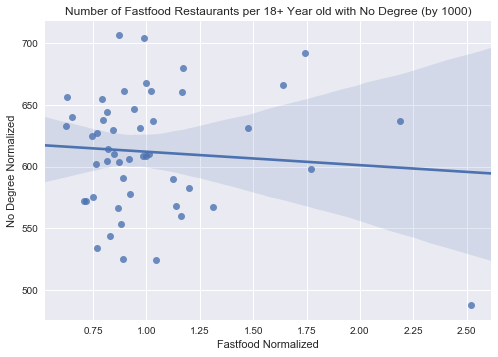

In [19]:
# Create Scatter Plot
y = 'No Degree Normalized'
x = 'Fastfood Normalized'
d = outputDF

# Show the results of a linear regression within each dataset
ax = sns.regplot(x=x, y=y, data=d)

plt.title('Number of Fastfood Restaurants per 18+ Year old with No Degree (by 1000)')

plt.show()

In [20]:
# Calculate r-squared and line equation
x = outputDF['No Degree Normalized']
y = outputDF['Fastfood Normalized']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

rsquare = r_value**2
intercept
slope

-0.00066703058579024356